In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax
from jax.numpy.linalg import norm as l2
import numpy as np
from typing import List, Dict, Tuple
from itertools import product

In [2]:
class ElasticNetwork(nx.Graph):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos = {}
    
    def energy(self, params=None) -> float:
        U = 0
        pos = self.pos if params is None else params
        for u, v, d in self.edges(data=True):
            r = l2(pos[u] - pos[v])
            dr = r - d['rest_length'] 
            U += d['weight'] * dr * dr
        return U
    
    def sample(self, length, init=None, seed=42, sigma=0.1, T=1, update=True) -> List[Dict]:
        """
        Do Metropolis Monte Carlo sampling of possible system configurations,
        and return them in a list. For every step, a random Gaussian noise is
        used to perturb the position of all nodes.
        """
        if init is None:
            init = dict(self.pos)
        rng_key = jax.random.PRNGKey(seed)
        traj = [init]
        
        @jax.jit # seems pretty fast
        def aux(rng_key):
            next_state = dict(traj[-1])
            for k, v in next_state.items(): # this part could be optimized later
                rng_key, key = jax.random.split(rng_key, 2)
                next_state[k] = v + jax.random.normal(key=key, shape=v.shape)*sigma
            E_last = self.energy(params=traj[-1])
            E_curr = self.energy(params=next_state)
            rng_key, key = jax.random.split(rng_key, 2)
            return rng_key, E_last, E_curr, next_state
        
        while length > 1:
            rng_key, E_last, E_curr, next_state = aux(rng_key)
            if np.random.uniform() <= min(1, np.exp(-1/T*(E_curr-E_last))): # kb=1
                traj.append(next_state)
                length-=1
            
        if update:
            self.pos = dict(traj[-1])
        return traj
        
    def minimize(self, epochs=100):
        params = dict(self.pos)
        optimizer = optax.sgd(learning_rate=0.1)
        opt_state = optimizer.init(params)
        
        @jax.jit
        def step(params, opt_state):
            loss_value, grads = jax.value_and_grad(self.energy)(params)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value

        for _ in range(epochs):
            params, opt_state, loss_value = step(params, opt_state)
            
        print(f"Energy after minimization: {loss_value}")
        self.pos = params
    
    def draw(self, figsize=(5,5)):
        fig = plt.figure(figsize=figsize)
        options = {'node_color': 'black', 'node_size': 100, 'width': 3, 'font_size': 8}
        nx.draw_networkx(self, pos=self.pos, **options)
        nx.draw_networkx_edge_labels(self, pos=self.pos, font_size=8,
                                     edge_labels={(u,v): f"({l['weight']:.2f},{l['rest_length']:.2f})"\
                                                  for u,v,l in self.edges(data=True)})
    
    def init_pos(self, *args, **kwargs):
        self.pos = nx.spring_layout(self, *args, **kwargs)
        for k, v in self.pos.items():
            self.pos[k] = jnp.array(v)
    
    def add_node(self, node_for_adding, *args, position=None, **kwargs):
        super().add_node(node_for_adding, *args, **kwargs)
        if position is not None:
            self.pos[node_for_adding] = jnp.array(position)
        
    def add_nodes(self, nodes_for_adding, *args, positions=None, **kwargs):
        for node, pos in zip(nodes_for_adding, positions):
            self.add_node(node_for_adding=node, *args, position=pos, **kwargs)
    
    def add_spring(self, v1, v2, weight, rest_length=None):
        if rest_length is None:
            rest_length = float(l2(self.pos[v1] - self.pos[v2]))
        self.add_edge(v1, v2, rest_length=rest_length, weight=weight)
        
    def add_springs(self, v1s: List, v2s: List, weights: List, rest_lengths: List):
        for v1, v2, weight, rest_length in zip(v1s, v2s, weights, rest_lengths):
            self.add_spring(v1, v2, weight, rest_length)

In [3]:
G = ElasticNetwork()
G.add_nodes(nodes_for_adding=range(4), 
            positions=[jnp.array([-0.5, -0.5]),
                       jnp.array([-0.5, 0.5]),
                       jnp.array([0.5, -0.5]),
                       jnp.array([0.5, 0.5])])
G.add_springs(v1s=[0, 1, 0, 0, 2, 1],
              v2s=[1, 2, 2, 3, 3, 3],
              weights=[1, 1, 1, 1, 1, 1],
              rest_lengths=[1, 1, 1, 1.2, 1.2, 1.5])

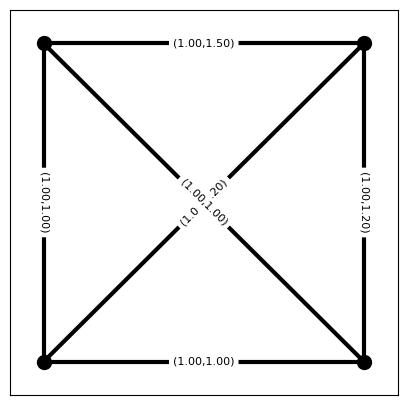

In [4]:
G.draw()

In [5]:
G.pos

{0: DeviceArray([-0.5, -0.5], dtype=float32),
 1: DeviceArray([-0.5,  0.5], dtype=float32),
 2: DeviceArray([ 0.5, -0.5], dtype=float32),
 3: DeviceArray([0.5, 0.5], dtype=float32)}

In [6]:
G.energy()

DeviceArray(0.5074603, dtype=float32)

In [7]:
G.minimize()

Energy after minimization: 0.28506138920783997


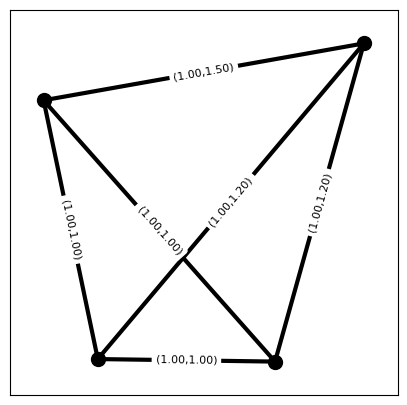

In [8]:
G.draw()

In [9]:
%%time
traj = G.sample(length=100_000, sigma=0.1)

CPU times: user 2.34 s, sys: 194 ms, total: 2.53 s
Wall time: 2.27 s


In [10]:
G.energy()

DeviceArray(0.2960294, dtype=float32)

(array([4.9408e+04, 3.5350e+04, 1.0992e+04, 3.0970e+03, 8.5300e+02,
        2.1700e+02, 5.5000e+01, 1.5000e+01, 7.0000e+00, 6.0000e+00]),
 array([0.28506136, 0.37089401, 0.45672667, 0.54255933, 0.62839198,
        0.71422464, 0.80005729, 0.88588995, 0.9717226 , 1.0575552 ,
        1.14338791]),
 <BarContainer object of 10 artists>)

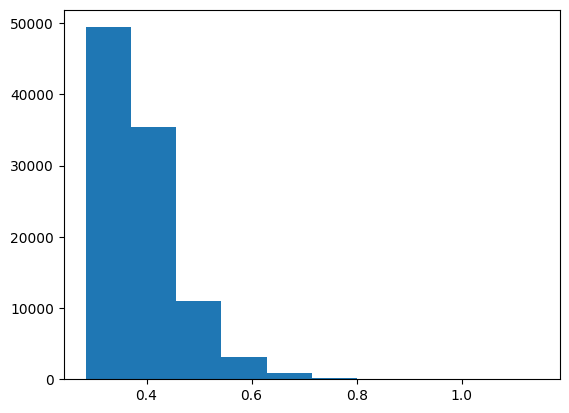

In [11]:
energy = []
for pos in traj:
    G.pos = pos
    energy.append(G.energy()) # pretty slow, can be optimized
plt.hist(energy)

In [12]:
def build_rectangular_mesh(width, height, dx=1., dy=1., weight=1, eps_weight=0, seed=42) -> ElasticNetwork:
    np.random.seed(42)
    EN = ElasticNetwork()
    def random_weight():
        return np.random.uniform(weight-eps_weight, weight+eps_weight)
    
    for nx, ny in product(range(width), range(height)):
        EN.add_node((nx,ny), position=(nx*dx, ny*dy))
    for nx, ny in product(range(width), range(height)):
        if nx < width-1:
            EN.add_spring((nx, ny), (nx+1, ny), 
                          weight=random_weight())
        if ny < height-1:
            EN.add_spring((nx, ny), (nx, ny+1),
                         weight=random_weight())
    return EN

In [13]:
mesh = build_rectangular_mesh(5, 5, eps_weight=0.05)

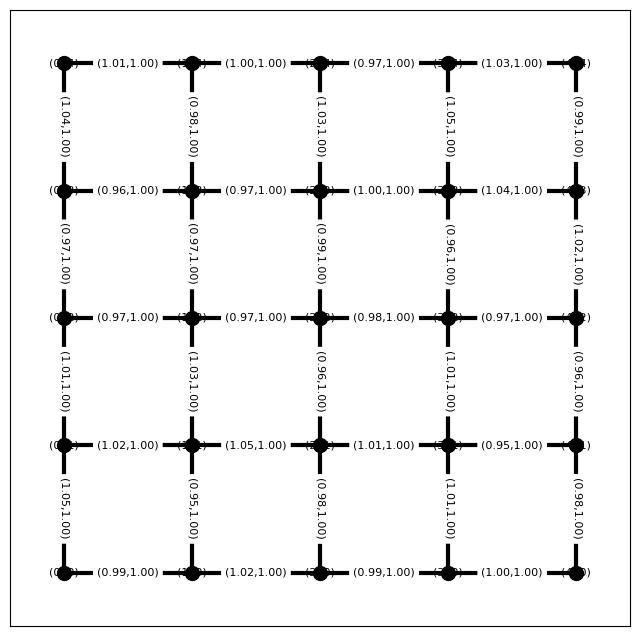

In [14]:
mesh.draw(figsize=(8,8))

In [15]:
%%time
traj=mesh.sample(length=1000)

CPU times: user 2.56 s, sys: 165 ms, total: 2.72 s
Wall time: 2.56 s


In [16]:
mesh.pos = traj[-100]

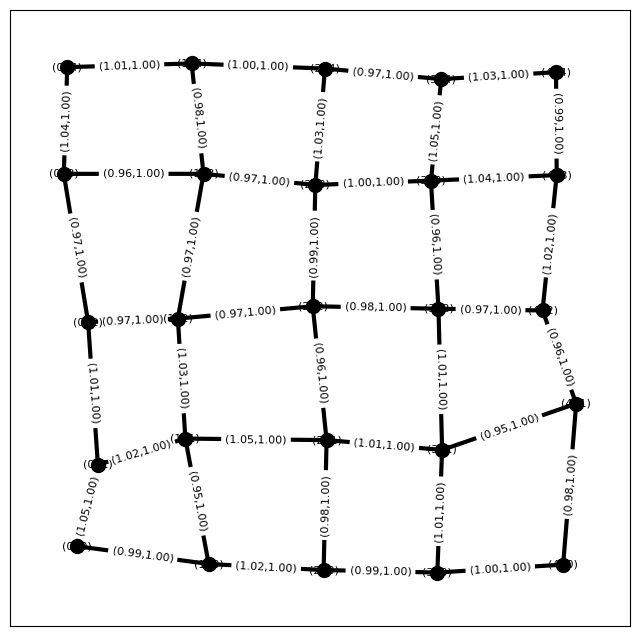

In [17]:
mesh.draw(figsize=(8,8))

In [18]:
mesh.energy()

DeviceArray(0.7602917, dtype=float32)

now we define a Graph Normalizing Flow network based on https://arxiv.org/abs/1905.13177.
    
The idea is that given a graph with additional vertex data describing node positions and edge data describing the spring constant for the link between every pair of nodes, we can evaluate the energy of the elastic network of the graph, and thus modulo translation and rotation of all coordinates, we have a well-defined canonical distribution over all graphs with the same connectivity and spring constants. This distribution can be modelled by a graph normalizing flow network that iteratively transforms a base distribution, e.g., Gaussian for all node coordinates, into this target distribution.


In [44]:
import jraph
import haiku as hk

n_hidden_dim = 16
output_dim=2
hidden_dim=16
half_dim = output_dim//2

# this is clearly inspired by RealNVP

def replace_node_features(g: jraph.GraphsTuple, new_nodes) -> jraph.GraphsTuple:
    nodes, edges, receivers, senders, globals_, n_node, n_edge = g
    return jraph.GraphsTuple(new_nodes, edges, receivers, senders, globals_, len(new_nodes), n_edge)

class GraphNetwork(hk.Module):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(name=name)
        self.model = jraph.GraphNetwork(*args, **kwargs)
    
    def __call__(self, g):
        return self.model(g)

class GRevHalfLayer(hk.Module):
    def __init__(self, dim, hidden_dim = 16, name=None):
        super().__init__(name=name)
        self.dim = dim
        self.half_dim = dim // 2
        assert dim % 2 == 0
        edge_output_sizes = [hidden_dim, hidden_dim, dim]
        node_output_sizes = [hidden_dim, hidden_dim, half_dim]
        # The MLP setup is for initial testing, and it works, 
        # but we will use MPNN since we work with graphs
        #self.mp_trans = hk.nets.MLP(output_sizes)  
        #self.mp_scale = hk.nets.MLP(output_sizes)
        def make_mlp_edge_update(activation):
            @jraph.concatenated_args
            def f(feats):
                return hk.nets.MLP(edge_output_sizes, activation=activation)(feats)
            return f
        # could have written lambda but I don't want to be that terse
        def make_mlp_node_update(activation):
            def f(node_feats, sender_feats, receiver_feats, global_feats):
                return hk.nets.MLP(node_output_sizes, activation=activation)(
                    jnp.concatenate([node_feats, receiver_feats], axis=1) # only aggr over msgs from incoming edges
                )
            return f
        # note, floating point error can accum at current precision
        self.mp_trans = GraphNetwork(update_edge_fn=make_mlp_edge_update(jax.nn.relu), 
                                     update_node_fn=make_mlp_node_update(jax.nn.relu), 
                                     update_global_fn=None)
        self.mp_scale = GraphNetwork(update_edge_fn=make_mlp_edge_update(jax.nn.relu), 
                                     update_node_fn=make_mlp_node_update(jax.nn.tanh), 
                                     update_global_fn=None)
        
    def forward(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        half_feats_0 = g.nodes[:, :self.half_dim]
        half_feats_1 = g.nodes[:, self.half_dim:]
        half_g_1 = replace_node_features(g, half_feats_1)
        scale, trans = self.mp_scale(half_g_1).nodes, self.mp_trans(half_g_1).nodes
        new_half_feats_0 = half_feats_0 * jnp.exp(scale) + trans
        new_nodes = g.nodes.at[:, :self.half_dim].set(new_half_feats_0)
        logdetJ = -jnp.sum(scale)
        g_new = replace_node_features(g, new_nodes)
        return g_new, logdetJ
    
    def reverse(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        half_feats_0 = g.nodes[:, :self.half_dim]
        half_feats_1 = g.nodes[:, self.half_dim:]
        half_g_1 = replace_node_features(g, half_feats_1)
        scale, trans = self.mp_scale(half_g_1).nodes, self.mp_trans(half_g_1).nodes
        new_half_feats_0 = (half_feats_0 - trans) / jnp.exp(scale)
        new_nodes = g.nodes.at[:, :self.half_dim].set(new_half_feats_0)
        logdetJ = jnp.sum(scale)
        g_new = replace_node_features(g, new_nodes)
        return g_new, logdetJ


# we put two half-layers together serially, but switching first and second half of 
# edge features in the middle, see the figure below this code block for viz.
class GRevLayer(hk.Module):
    def __init__(self, dim, hidden_dim = 16, name=None):
        super().__init__(name=name)
        self.dim = dim
        self.half_dim = dim // 2
        self.half_layer1 = GRevHalfLayer(dim, hidden_dim)
        self.half_layer2 = GRevHalfLayer(dim, hidden_dim)
    
    def swap(self, g: jraph.GraphsTuple) -> jraph.GraphsTuple:
        return replace_node_features(g, jnp.concatenate([g.nodes[:, self.half_dim:], 
                                                         g.nodes[:, :self.half_dim]], axis=1))
        
    def forward(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        g, ldj1 = self.half_layer1.forward(g) 
        g = self.swap(g)
        g, ldj2 = self.half_layer2.forward(g)
        return g, ldj1+ldj2
        
    def reverse(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        g, ldj1 = self.half_layer2.reverse(g)
        g = self.swap(g)
        g, ldj2 = self.half_layer1.reverse(g)
        return g, ldj1+ldj2
    

class GRevNet(hk.Module):
    def __init__(self, n_layers, dim, hidden_dim=16, name=None):
        super().__init__(name=name)
        self.layers = [GRevLayer(dim, hidden_dim) for _ in range(n_layers)]
        
    def forward(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        ldj_sum = 0
        for layer in self.layers:
            g, ldj = layer.forward(g)
            ldj_sum += ldj
        return g, ldj_sum
        
    def reverse(self, g: jraph.GraphsTuple) -> Tuple[jraph.GraphsTuple, jnp.ndarray]:
        ldj_sum = 0
        for layer in self.layers[::-1]:
            g, ldj = layer.reverse(g)
            ldj_sum += ldj
        return g, ldj_sum
    

def pos_dict_to_arr(d) -> jnp.array:
    """ Helper function for converting networkx pos dictionary to keys and node features """
    return [*d.keys()], jnp.stack([*d.values()])

def en_to_graph(en: ElasticNetwork) -> jraph.GraphsTuple:
    """ Convert ElasticNetwork to Jraph GraphsTuple """
    n_node = en.number_of_nodes()
    n_edge = en.number_of_edges() * 2  # undirected -> directed, dup edges
    n_global = 0
    d_node = 2
    d_edge = 2
    d_global = 0
    keys, node_feats = pos_dict_to_arr(en.pos)
    edge_feats = jnp.array([[*d.values()] for _, _, d in mesh.edges(data=True)])
    edge_feats = jnp.concatenate([edge_feats, edge_feats], axis=0) # duplicate
    global_feats = None
    # convert undirected network into directed graph required by jraph
    sender_nodes = jnp.array([keys.index(edge[0]) for edge in en.edges] + [keys.index(edge[1]) for edge in en.edges])
    receiver_nodes = jnp.array([keys.index(edge[1]) for edge in en.edges] + [keys.index(edge[0]) for edge in en.edges])
    g = jraph.GraphsTuple(n_node=n_node, n_edge=n_edge, nodes=node_feats, edges=edge_feats,
                         globals=global_feats, senders=sender_nodes, receivers=receiver_nodes)
    return g

def graph_to_en(g: jraph.GraphsTuple) -> ElasticNetwork:
    """ Convert Jraph GraphsTuple to ElasticNetwork """
    en = ElasticNetwork()
    
    return en

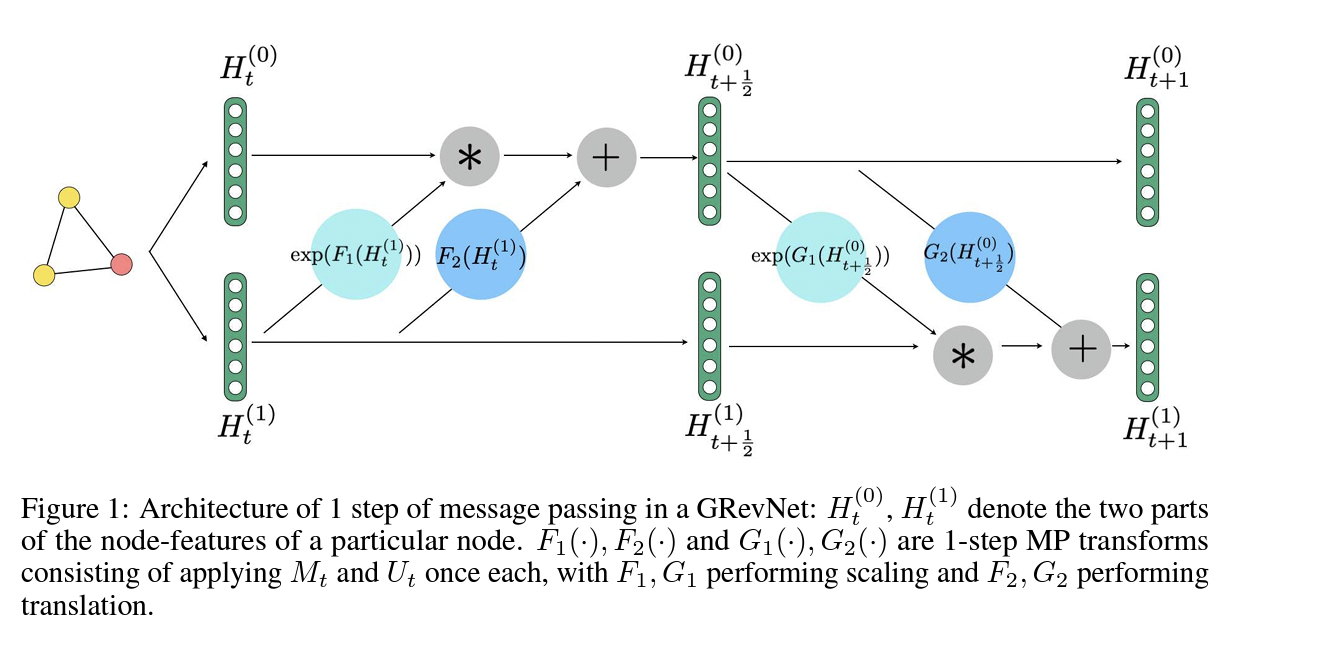

This is one single block of Reversible Graph Neural Networks.

In [20]:
mesh_graph = en_to_graph(mesh)

In [46]:
def invert_test(g):
    m = GRevNet(n_layers=4, dim=2, hidden_dim=16)
    g, ld_fwd = m.forward(g)
    g, ld_rev = m.reverse(g)
    jax.debug.print(f"Log det of Jacobian, fwd: {ld_fwd:.2f}, rev: {ld_rev:.2f}")
    return g

rng_key = jax.random.PRNGKey(42)
invert_test = hk.without_apply_rng(hk.transform(invert_test))
params_invert_test = invert_test.init(rng=rng_key, g=mesh_graph)
output = invert_test.apply(params=params_invert_test, g=mesh_graph)

output


Log det of Jacobian, fwd: -11.43, rev: 11.43
Log det of Jacobian, fwd: -11.43, rev: 11.43


GraphsTuple(nodes=DeviceArray([[-3.1754624e-03,  1.3152450e-01],
             [ 1.7404096e-01,  7.7999109e-01],
             [ 9.1943860e-02,  1.9156020e+00],
             [-1.1232279e-01,  3.0955124e+00],
             [-8.3369568e-02,  3.9449558e+00],
             [ 1.1051450e+00, -1.0482861e-02],
             [ 9.0910810e-01,  9.8800218e-01],
             [ 8.4600639e-01,  1.9430946e+00],
             [ 1.0615956e+00,  3.0957401e+00],
             [ 9.6179581e-01,  3.9744470e+00],
             [ 2.0709159e+00, -5.8734003e-02],
             [ 2.0956438e+00,  9.7589779e-01],
             [ 1.9795169e+00,  2.0415461e+00],
             [ 2.0010934e+00,  3.0072565e+00],
             [ 2.0821540e+00,  3.9336274e+00],
             [ 3.0260897e+00, -7.8497045e-02],
             [ 3.0664167e+00,  8.9778936e-01],
             [ 3.0358996e+00,  2.0218117e+00],
             [ 2.9725921e+00,  3.0414321e+00],
             [ 3.0593026e+00,  3.8498693e+00],
             [ 4.0834737e+00, -1.5303973e-

In [23]:
mesh_graph

GraphsTuple(nodes=DeviceArray([[-3.1755078e-03,  1.3152450e-01],
             [ 1.7404099e-01,  7.7999109e-01],
             [ 9.1943853e-02,  1.9156023e+00],
             [-1.1232275e-01,  3.0955124e+00],
             [-8.3369538e-02,  3.9449556e+00],
             [ 1.1051446e+00, -1.0482828e-02],
             [ 9.0910798e-01,  9.8800212e-01],
             [ 8.4600669e-01,  1.9430940e+00],
             [ 1.0615956e+00,  3.0957403e+00],
             [ 9.6179587e-01,  3.9744473e+00],
             [ 2.0709159e+00, -5.8733996e-02],
             [ 2.0956438e+00,  9.7589785e-01],
             [ 1.9795169e+00,  2.0415461e+00],
             [ 2.0010931e+00,  3.0072560e+00],
             [ 2.0821543e+00,  3.9336276e+00],
             [ 3.0260897e+00, -7.8497052e-02],
             [ 3.0664172e+00,  8.9778936e-01],
             [ 3.0358989e+00,  2.0218120e+00],
             [ 2.9725914e+00,  3.0414326e+00],
             [ 3.0593030e+00,  3.8498695e+00],
             [ 4.0834732e+00, -1.5303996e-